In [10]:
import glob
import torch
from torch.utils import data
from PIL import Image
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt

#通过创建data.Dataset子类Mydataset来创建输入
class Mydataset(data.Dataset):
# 类初始化
    def __init__(self, root):
        self.imgs_path = root
# 进行切片
    def __getitem__(self, index):
        img_path = self.imgs_path[index]
        return img_path
# 返回长度
    def __len__(self):
        return len(self.imgs_path)



60
60
['/home/lyc/doc/AML_LAB/img_data/True_2zimo.png', '/home/lyc/doc/AML_LAB/img_data/False_9che.png', '/home/lyc/doc/AML_LAB/img_data/False_8che.png']
['/home/lyc/doc/AML_LAB/img_data/True_3xizhi.png', '/home/lyc/doc/AML_LAB/img_data/True_5zimo.png', '/home/lyc/doc/AML_LAB/img_data/True_10xizhi.png', '/home/lyc/doc/AML_LAB/img_data/False_3zimo.png', '/home/lyc/doc/AML_LAB/img_data/True_2che.png']
{'False': 0, 'True': 1}
{0: 'False', 1: 'True'}
torch.Size([10, 3, 240, 320])


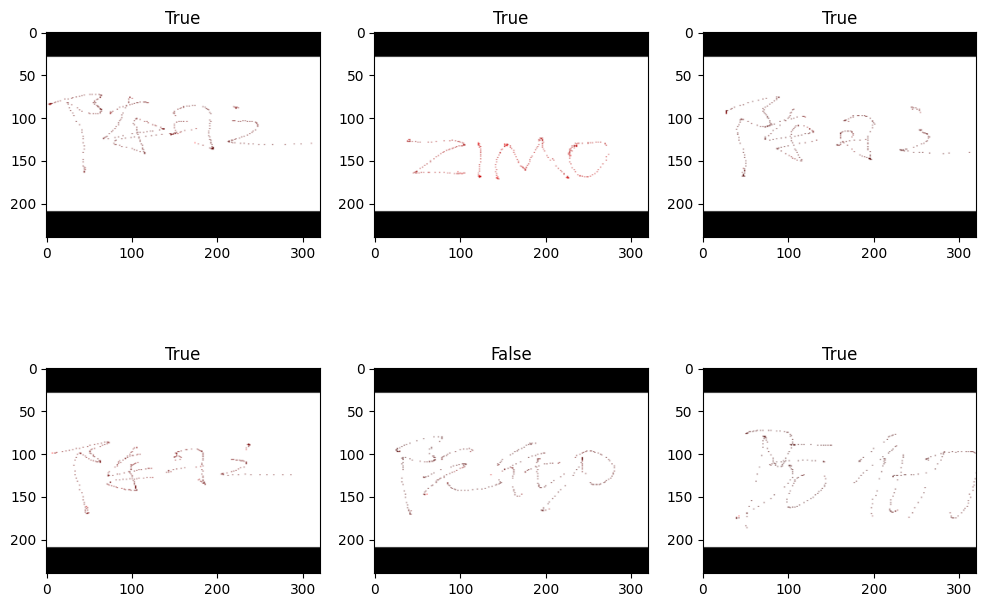

In [11]:
#使用glob方法来获取数据图片的所有路径
all_imgs_path = glob.glob(r'/home/lyc/doc/AML_LAB/img_data/*.png')#数据文件夹路径，根据实际情况更改！
#循环遍历输出列表中的每个元素，显示出每个图片的路径
sample_size=0
for var in all_imgs_path:
    sample_size+=1

print(sample_size)

#利用自定义类Mydataset创建对象weather_dataset
signature_dataset = Mydataset(all_imgs_path)
print(len(signature_dataset)) #返回文件夹中图片总个数
print(signature_dataset[12:15])#切片，显示第12至第十五张图片的路径
sinature_datalodaer = torch.utils.data.DataLoader(signature_dataset, batch_size=5) #每次迭代时返回五个数据
print(next(iter(sinature_datalodaer)))

species = ['False','True']
species_to_id = dict((c, i) for i, c in enumerate(species))
print(species_to_id)
id_to_species = dict((v, k) for k, v in species_to_id.items())
print(id_to_species)
all_labels = []
#对所有图片路径进行迭代
for img in all_imgs_path:
    # 区分出每个img，应该属于什么类别
    for i, c in enumerate(species):
        if c in img:
            all_labels.append(i)
#print(all_labels) #得到所有标签
            

            
# 对数据进行转换处理
transform = transforms.Compose([
                transforms.Resize((240,320)), #做的第一步转换
                transforms.ToTensor() #第二步转换，作用：第一转换成Tensor，第二将图片取值范围转换成0-1之间，第三会将channel置前
])

class Mydatasetpro(data.Dataset):
# 类初始化
    def __init__(self, img_paths, labels, transform):
        self.imgs = img_paths
        self.labels = labels
        self.transforms = transform
# 进行切片
    def __getitem__(self, index):                #根据给出的索引进行切片，并对其进行数据处理转换成Tensor，返回成Tensor
        img = self.imgs[index]
        label = self.labels[index]
        pil_img = Image.open(img)                 #pip install pillow
        data = self.transforms(pil_img)
        return data, label
# 返回长度
    def __len__(self):
        return len(self.imgs)



BATCH_SIZE = 10
signature_dataset = Mydatasetpro(all_imgs_path, all_labels, transform)
sinature_datalodaer = data.DataLoader(
                            signature_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True
)

imgs_batch, labels_batch = next(iter(sinature_datalodaer))
print(imgs_batch.shape)

plt.figure(figsize=(12, 8))
for i, (img, label) in enumerate(zip(imgs_batch[:6], labels_batch[:6])):
    img = img.permute(1, 2, 0).numpy()
    plt.subplot(2, 3, i+1)
    plt.title(id_to_species.get(label.item()))
    plt.imshow(img)
plt.show()#展示图片


In [12]:
import pandas as pd 

#划分测试集和训练集
index = np.random.permutation(len(all_imgs_path))

all_imgs_path = np.array(all_imgs_path)[index]
all_labels = np.array(all_labels)[index]

#80% as train
s = int(len(all_imgs_path)*0.7)
print(s)

train_imgs = all_imgs_path[:s]
train_labels = all_labels[:s]
test_imgs = all_imgs_path[s:]
test_labels = all_labels[s:]





print(test_labels)
train_ds = Mydatasetpro(train_imgs, train_labels, transform) #TrainSet TensorData
test_ds = Mydatasetpro(test_imgs, test_labels, transform) #TestSet TensorData

print(train_ds)
train_imgs = pd.get_dummies(train_imgs)
test_imgs = pd.get_dummies(test_imgs)
#print(train_ds)

train_dl = data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)#TrainSet Labels
test_dl = data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)#TestSet Labels






42
[0 1 0 0 1 0 1 0 1 0 1 1 1 0 0 0 0 1]


## 训练

## Resnet

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader
from torchvision import models
from torchsummary import summary
# 假设您的数据集已经准备好，包括训练集和验证集
# 这里仅作示例，您需要根据实际情况修改数据加载部分




# 初始化ResNet模型
model_resnet = resnet18(pretrained=True)
num_classes = 2
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, num_classes)




# 设置优化器和损失函数
optimizer = optim.Adam(model_resnet.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# 训练模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_resnet.to(device)

for epoch in range(30):  # 假设训练30个epoch
    model_resnet.train()
    running_loss = 0.0
    for images, labels in train_dl:
        images, labels = images.to(device), labels.to(device)  # 将图像和标签分别移动到设备上
        optimizer.zero_grad()
        outputs = model_resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/30], Loss: {running_loss / len(train_dl)}")



summary(model_resnet, input_size=(3,256,256), batch_size=-1, device='cuda')
# 验证模型


model_resnet.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_dl:
        images, labels = images.to(device), labels.to(device)  # 将图像和标签分别移动到设备上
        outputs = model_resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Validation Accuracy: {100 * correct / total:.2f}%")


/home/lyc/anaconda3/envs/mix/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lyc/anaconda3/envs/mix/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/30], Loss: 0.8838308334350586
Epoch [2/30], Loss: 0.9353702545166016
Epoch [3/30], Loss: 0.6508178859949112
Epoch [4/30], Loss: 0.38450523614883425
Epoch [5/30], Loss: 0.10704402402043342
Epoch [6/30], Loss: 0.07173663722351194
Epoch [7/30], Loss: 0.007793436269275844
Epoch [8/30], Loss: 0.09338350978214294
Epoch [9/30], Loss: 0.3111613097600639
Epoch [10/30], Loss: 0.009219985944218934
Epoch [11/30], Loss: 0.33969179322011767
Epoch [12/30], Loss: 0.6398993079550565
Epoch [13/30], Loss: 0.06190137267112732
Epoch [14/30], Loss: 0.194954464584589
Epoch [15/30], Loss: 0.06999664176255464
Epoch [16/30], Loss: 0.390950876288116
Epoch [17/30], Loss: 0.1079573817551136
Epoch [18/30], Loss: 0.36504161832854154
Epoch [19/30], Loss: 0.43391585126519205
Epoch [20/30], Loss: 0.15903259520418941
Epoch [21/30], Loss: 0.380623297393322
Epoch [22/30], Loss: 0.2058778027072549
Epoch [23/30], Loss: 0.04582102159038186
Epoch [24/30], Loss: 0.15718331933021545
Epoch [25/30], Loss: 0.1207270368933

## VGG16

In [14]:
from torchvision.models import vgg16  # 更改这里导入VGG模型

model_vgg = vgg16(pretrained=True)
num_classes = 2
# VGG的分类器是一个Sequential模块，最后一层是一个全连接层
model_vgg.classifier[6] = nn.Linear(model_vgg.classifier[6].in_features, num_classes)  # 修改VGG最后的全连接层

# 设置优化器和损失函数
optimizer = optim.Adam(model_vgg.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# 训练模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_vgg.to(device)

for epoch in range(30):  # 假设训练30个epoch
    model_vgg.train()
    running_loss = 0.0
    for images, labels in train_dl:  # 确保train_dl是你的训练数据加载器
        images, labels = images.to(device), labels.to(device)  # 将图像和标签分别移动到设备上
        optimizer.zero_grad()
        outputs = model_vgg(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/30], Loss: {running_loss / len(train_dl)}")

# 模型摘要
summary(model_vgg, input_size=(3, 256, 256), batch_size=-1, device='cuda')

# 验证模型
model_vgg.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_dl:  # 确保test_dl是你的测试数据加载器
        images, labels = images.to(device), labels.to(device)
        outputs = model_vgg(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Validation Accuracy: {100 * correct / total:.2f}%")

/home/lyc/anaconda3/envs/mix/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/30], Loss: 1.5828820705413817
Epoch [2/30], Loss: 1.3949289798736573
Epoch [3/30], Loss: 0.7911491751670837
Epoch [4/30], Loss: 0.8221811890602112
Epoch [5/30], Loss: 0.7493616461753845
Epoch [6/30], Loss: 0.7579995393753052
Epoch [7/30], Loss: 0.7442229866981507
Epoch [8/30], Loss: 0.68280428647995
Epoch [9/30], Loss: 0.7325232744216919
Epoch [10/30], Loss: 0.6980208158493042
Epoch [11/30], Loss: 0.6868457078933716
Epoch [12/30], Loss: 0.7349639177322388
Epoch [13/30], Loss: 0.7113053798675537
Epoch [14/30], Loss: 0.6838742375373841
Epoch [15/30], Loss: 0.6829276919364929
Epoch [16/30], Loss: 0.7685831785202026
Epoch [17/30], Loss: 0.7756960988044739
Epoch [18/30], Loss: 0.7411011815071106
Epoch [19/30], Loss: 0.7003239035606384
Epoch [20/30], Loss: 0.6907495975494384
Epoch [21/30], Loss: 0.7203950643539428
Epoch [22/30], Loss: 0.7025833010673523
Epoch [23/30], Loss: 0.6983819246292114
Epoch [24/30], Loss: 0.7102731108665467
Epoch [25/30], Loss: 0.7134529709815979
Epoch [26/3

In [15]:
from torchvision import models

model_alex = models.alexnet(pretrained=True)
num_classes = 2
# VGG的分类器是一个Sequential模块，最后一层是一个全连接层
model_alex.classifier[6] = nn.Linear(model_alex.classifier[6].in_features, num_classes)  # 修改VGG最后的全连接层

# 设置优化器和损失函数
optimizer = optim.Adam(model_alex.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# 训练模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_alex.to(device)

for epoch in range(30):  # 假设训练30个epoch
    model_alex.train()
    running_loss = 0.0
    for images, labels in train_dl:  # 确保train_dl是你的训练数据加载器
        images, labels = images.to(device), labels.to(device)  # 将图像和标签分别移动到设备上
        optimizer.zero_grad()
        outputs = model_alex(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/30], Loss: {running_loss / len(train_dl)}")

# 模型摘要
summary(model_alex, input_size=(3, 256, 256), batch_size=-1, device='cuda')

# 验证模型
model_alex.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_dl:  # 确保test_dl是你的测试数据加载器
        images, labels = images.to(device), labels.to(device)
        outputs = model_alex(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Validation Accuracy: {100 * correct / total:.2f}%")

/home/lyc/anaconda3/envs/mix/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/30], Loss: 1.5801558017730712
Epoch [2/30], Loss: 0.6979103565216065
Epoch [3/30], Loss: 0.7009559154510498
Epoch [4/30], Loss: 0.7633049368858338
Epoch [5/30], Loss: 0.7095882415771484
Epoch [6/30], Loss: 0.6981782793998719
Epoch [7/30], Loss: 0.6977434277534484
Epoch [8/30], Loss: 0.6989359736442566
Epoch [9/30], Loss: 0.6982703924179077
Epoch [10/30], Loss: 0.6945689558982849
Epoch [11/30], Loss: 0.6856080651283264
Epoch [12/30], Loss: 0.6825359463691711
Epoch [13/30], Loss: 0.6760326266288758
Epoch [14/30], Loss: 0.7747336983680725
Epoch [15/30], Loss: 0.6705744624137878
Epoch [16/30], Loss: 0.7584932208061218
Epoch [17/30], Loss: 0.7472507357597351
Epoch [18/30], Loss: 0.6726240515708923
Epoch [19/30], Loss: 0.7277260422706604
Epoch [20/30], Loss: 0.6854767024517059
Epoch [21/30], Loss: 0.7049086093902588
Epoch [22/30], Loss: 0.6861054539680481
Epoch [23/30], Loss: 0.6871355056762696
Epoch [24/30], Loss: 0.6975295662879943
Epoch [25/30], Loss: 0.6904481887817383
Epoch [26

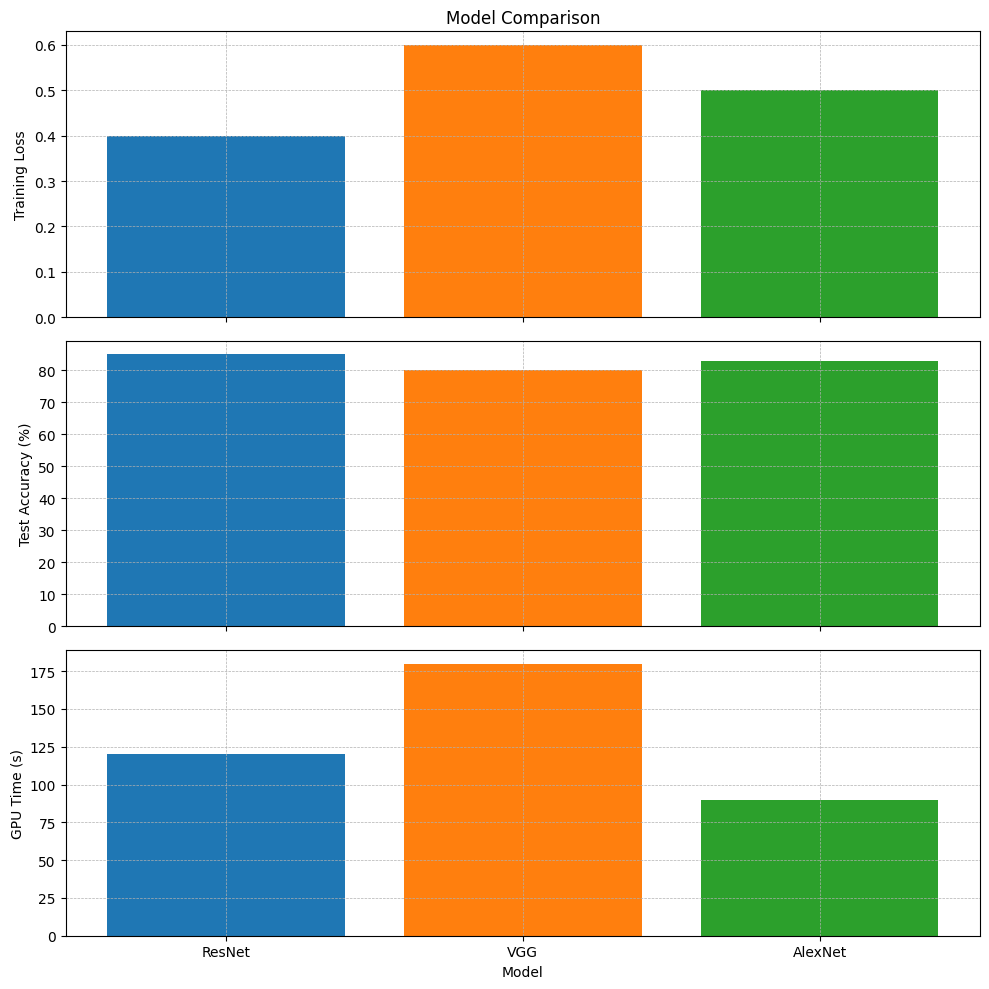

In [16]:
import matplotlib.pyplot as plt

# 假设数据
models = ['ResNet', 'VGG', 'AlexNet']
training_losses = [0.4, 0.6, 0.5]  # 每个模型的训练损失
test_accuracies = [85, 80, 83]  # 每个模型的测试准确率
gpu_times = [120, 180, 90]  # 每个模型的GPU时间（秒）

# 设定颜色方案
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

# 绘制训练损失图
axs[0].bar(models, training_losses, color=colors)
axs[0].set_ylabel('Training Loss')
axs[0].set_title('Model Comparison')
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# 绘制测试准确率图
axs[1].bar(models, test_accuracies, color=colors)
axs[1].set_ylabel('Test Accuracy (%)')
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)

# 绘制GPU时间图
axs[2].bar(models, gpu_times, color=colors)
axs[2].set_ylabel('GPU Time (s)')
axs[2].set_xlabel('Model')
axs[2].grid(True, which='both', linestyle='--', linewidth=0.5)

# 调整子图布局
plt.tight_layout()

plt.show()
